# Métodos de Monte Carlo

Juan Sosa PhD

Email jcsosam@unal.edu.co

GitHub https://github.com/jstats1702

Samuel Sánchez (Python y revisión R)

Email ssanchezgu@unal.edu.co

GitHub https://github.com/Samuel-col

In [1]:
# Recuerde instalar todas las librerías aquí llamadas antes de corre esta celda. Ésto lo puede hacer con conda o pip.
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from arviz import ess

## 1 Motivación: modelo Normal con una distribución previa semi-conjugada

En la mayoría de los casos **no es posible obtener directamente muestras la distribución posterior**.

Considere especificar Su estado de información previo acerca de $\theta$ de manera **independiente** de $\sigma^2$ de forma que:
$$
p(\theta,\sigma^2) = p(\theta)\,p(\sigma^2)\,.
$$
Esta formulación es mas **flexible** porque no hay una restricción de dependencia a priori entre $\theta$ y $\sigma^2$.

Asumiendo que las observaciones dadas en $\boldsymbol{y} = (y_1,\ldots,y_n)$ son intercambiables, bajo el **modelo Normal con una distribución previa semi-conjugada** se tiene que:

- **Verosimilitud**:
$$
y_i\mid\theta,\sigma^2 \stackrel{\text{iid}}{\sim} \textsf{N}(\theta,\sigma^2)\,,\qquad i=1,\ldots,n.
$$
- **Previa**:
$$
\begin{align*}
\theta   &\sim \textsf{N}(\mu_0, \tau^2_0) \\
\sigma^2 &\sim \textsf{GI}\left(\tfrac{\nu_0}{2},\tfrac{\nu_0\,\sigma^2_0}{2}\right)
\end{align*}
$$

- **Hiperparámetros**: $\mu_0$, $\tau^2_0$, $\nu_0$, y $\sigma^2_0$.

En el caso de la previa conjugada (donde $\tau_0^2$ es proporcional a $\sigma^2$) se tiene que la distribución posterior de $\sigma^2$ es Gamma Inversa. En este caso, **la distribución posterior de $\sigma^2$ no sigue una distribución estándar conocida** de la cual se pueda obtener muestras directamente.


### 1.1 Distribuciones condicionales completas

El **muestreador de Gibbs** (*Gibbs sampler*) es un algoritmo iterativo que permite **obtener muestras dependientes** de la **distribución posterior** por medio de las **distribuciones condicionales completas**.

Bajo esta especificación del modelo Normal, se demuestra que:

- La distribución condicional completa de $\theta$ es $\theta\mid\sigma^2,\boldsymbol{y}\sim\textsf{N}(\mu_n,\tau^2_n)$, donde
$$
\mu_n = \frac{\frac{1}{\tau^2_0}\mu_0 + \frac{n}{\sigma^2}\bar{y}}{\frac{1}{\tau^2_0} + \frac{n}{\sigma^2}} \qquad\text{y}\qquad\tau^2_n=\frac{1}{\frac{1}{\tau^2_0} + \frac{n}{\sigma^2}}\,.
$$
- La distribución condicional completa de $\sigma^2$ es $\sigma^2\mid\theta,\boldsymbol{y}\sim\textsf{GI}\left(\tfrac{\nu_n}{2},\tfrac{\nu_n\,\sigma^2_n}{2}\right)$, donde
$$
\nu_n = \nu_0+n\qquad\text{y}\qquad\sigma^2_n = \frac{1}{\nu_n}\left( \nu_0\sigma^2_0 + ns^2(\theta) \right)\,.
$$
con $s^2(\theta) = \tfrac{1}{n}\sum_{i=1}^n (y_i-\theta)^2 = (n-1)s^2 + n(\bar{y}-\theta)^2$, el cual corresponde al estimardor insesgado de $\sigma^2$ si $\theta$ fuera conocido. 


## 2 Muetreador de Gibbs

Dado un **estado actual** de los parámetros del modelo $\boldsymbol{\theta}^{(b)} = \left(\theta^{(b)}, (\sigma^2)^{(b)}\right)$, se genera un nuevo estado $\boldsymbol{\theta}^{(b+1)}$ como sigue:

1. Muestrear $\theta^{(b+1)}\sim p(\theta\mid(\sigma^2)^{(b)}, \boldsymbol{y})$.
2. Muestrear $(\sigma^2)^{(b+1)}\sim p(\sigma^2\mid\theta^{(b+1)}, \boldsymbol{y})$.
3. Establecer $\boldsymbol{\theta}^{(b+1)} = \left(\theta^{(b+1)}, (\sigma^2)^{(b+1)}\right)$. 
4. Repetir los pasos 1. a 3. hasta convergencia.

Este algoritmo se denomina **muestreador de Gibbs** y genera una **secuencia dependiente** de parámetros $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ de la distribución posterior $p(\theta,\sigma^2\mid \boldsymbol{y})$. 

Como punto de partida, solo es necesario proporcionar un valor inicial para $\sigma^2$. Usualmente este valor se muestra de la distribución previa correspondiente, esto es, $(\sigma^2)^{(0)}\sim\textsf{IG}\left(\tfrac{\nu_0}{2},\tfrac{\nu_0\,\sigma^2_0}{2}\right)$.


### 2.1 Ejemplo: Muestreador de Gibbs para el modelo Normal

En 1981, los biólogos W. L. Grogan y W. W. Wirth descubrieron en las selvas de 
Brasil dos nuevas variedades de un diminuto insecto picador llamado mosquito 
(*midge*). Llamaron a un tipo de mosquito Apf y al otro mosquito Af. 
Los biólogos descubrieron que el mosquito Apf es portador de una enfermedad 
debilitante que causa inflamación del cerebro cuando un humano está mordido 
por un mosquito infectado. Aunque la enfermedad rara vez es fatal, la 
discapacidad causada por la hinchazón puede ser permanente. La otra forma de 
mosquito, el Af, es bastante inofensiva y un valioso polinizador. 
En un esfuerzo por distinguir las dos variedades, los biólogos tomaron medidas 
en los mosquitos que capturaron. Este es un conjunto de datos valioso para 
probar métodos de clasificación.


***Grogan Jr, W. L., & Wirth, W. W. (1981). A new American genus of predaceous midges related to Palpomyia and Bezzia (Diptera: Ceratopogonidae). Proceedings of the Biological Society of Washington., 94(4), 1279-1305.***

<!--
```{r, eval = TRUE, echo=FALSE, out.width="75%", fig.pos = 'H', fig.align = 'center'}
knitr::include_graphics("modelo_normal_midge.png")
```
-->
![](modelo_normal_midge.png)

Considere los datos de la **longitud del ala en milímetros** ($y$) de $n=9$ miembros de 
la **especie Af de mosquitos**. A partir de estas nueve mediciones, se quiere 
hacer inferencia sobre la **media poblacional** $\theta$. 

Otros estudios sugieren que 
la longitud de las alas suele ser de alrededor de 1.9 mm. Claramente, se tiene 
que las longitudes deben ser positivas, lo que implica que $\theta > 0$.

Los datos de Grogan y Wirth se encuentran disponibles en la librería `Flury` de R, pero esta librería no se encuentra disponible para versiones reciente de R.


#### Muestreador de Gibbs

In [2]:
# datos
y = np.array([1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08])
# tamaño de la muestra
n = len(y)
# estadísticos
mean_y = np.mean(y)
mean_y

1.8044444444444447

In [3]:
var_y = np.var(y,ddof = 1)
var_y

0.016877777777777787

In [4]:
sum_y = np.sum(y)
sum_y

16.240000000000002

In [5]:
# hiperparametros
mu0 = 1.9
t20 = 0.5**2
s20 = 0.01
nu0 = 1
# numero de muestras
B = int(1e5)
# matriz para almacenar las muestras
PHI = []
# mostrar anuncios cada 10% de las iteraciones
ncat = np.floor(B/10)
# ALGORITMO (muestreador de Gibbs)
# 1. inicializar la cadena
#    valor inicial: simular de la previa
#    solo es necesario alguno de los valores
np.random.seed(1234)
theta = st.norm.rvs(mu0, scale = np.sqrt(t20), size = 1)
isig2 = st.gamma.rvs(nu0/2, scale = 2/(nu0*s20), size = 1)
PHI.append([theta,isig2])
# 2. simular iterativamente de las distribuciones condicionales completas
np.random.seed(1234)
for b in range(1,B):
    # 2.1 actualizar el valor de theta
    t2n = 1/(1/t20 + n*isig2)
    mun = (mu0/t20 + sum_y*isig2)*t2n
    theta = st.norm.rvs(mun, scale = np.sqrt(t2n), size = 1)
    # 2.2 actualizar el valor de sigma^2
    nun = nu0 + n
    s2n = (nu0*s20 + (n-1)*var_y + n*(mean_y - theta)**2)/nun
    isig2 = st.gamma.rvs(nun/2, scale = 2/(nun*s2n), size = 1)
    # 2.3 almacenar
    PHI.append([theta,isig2])
    # 2.4 progreso
    if ((b+1)%ncat == 0):
        print(100*np.round(b/B,1), "% completado ... ")

PHI = np.array(PHI)[:,:,0]

10.0 % completado ... 
20.0 % completado ... 
30.0 % completado ... 
40.0 % completado ... 
50.0 % completado ... 
60.0 % completado ... 
70.0 % completado ... 
80.0 % completado ... 
90.0 % completado ... 
100.0 % completado ... 


In [6]:
PHI[:6,:]

array([[ 2.13571758, 38.3211147 ],
       [ 1.8307793 , 33.55340142],
       [ 1.84356794, 79.12729325],
       [ 1.83709923, 44.2668239 ],
       [ 1.78891335, 92.6829787 ],
       [ 1.84462432, 89.67901834]])

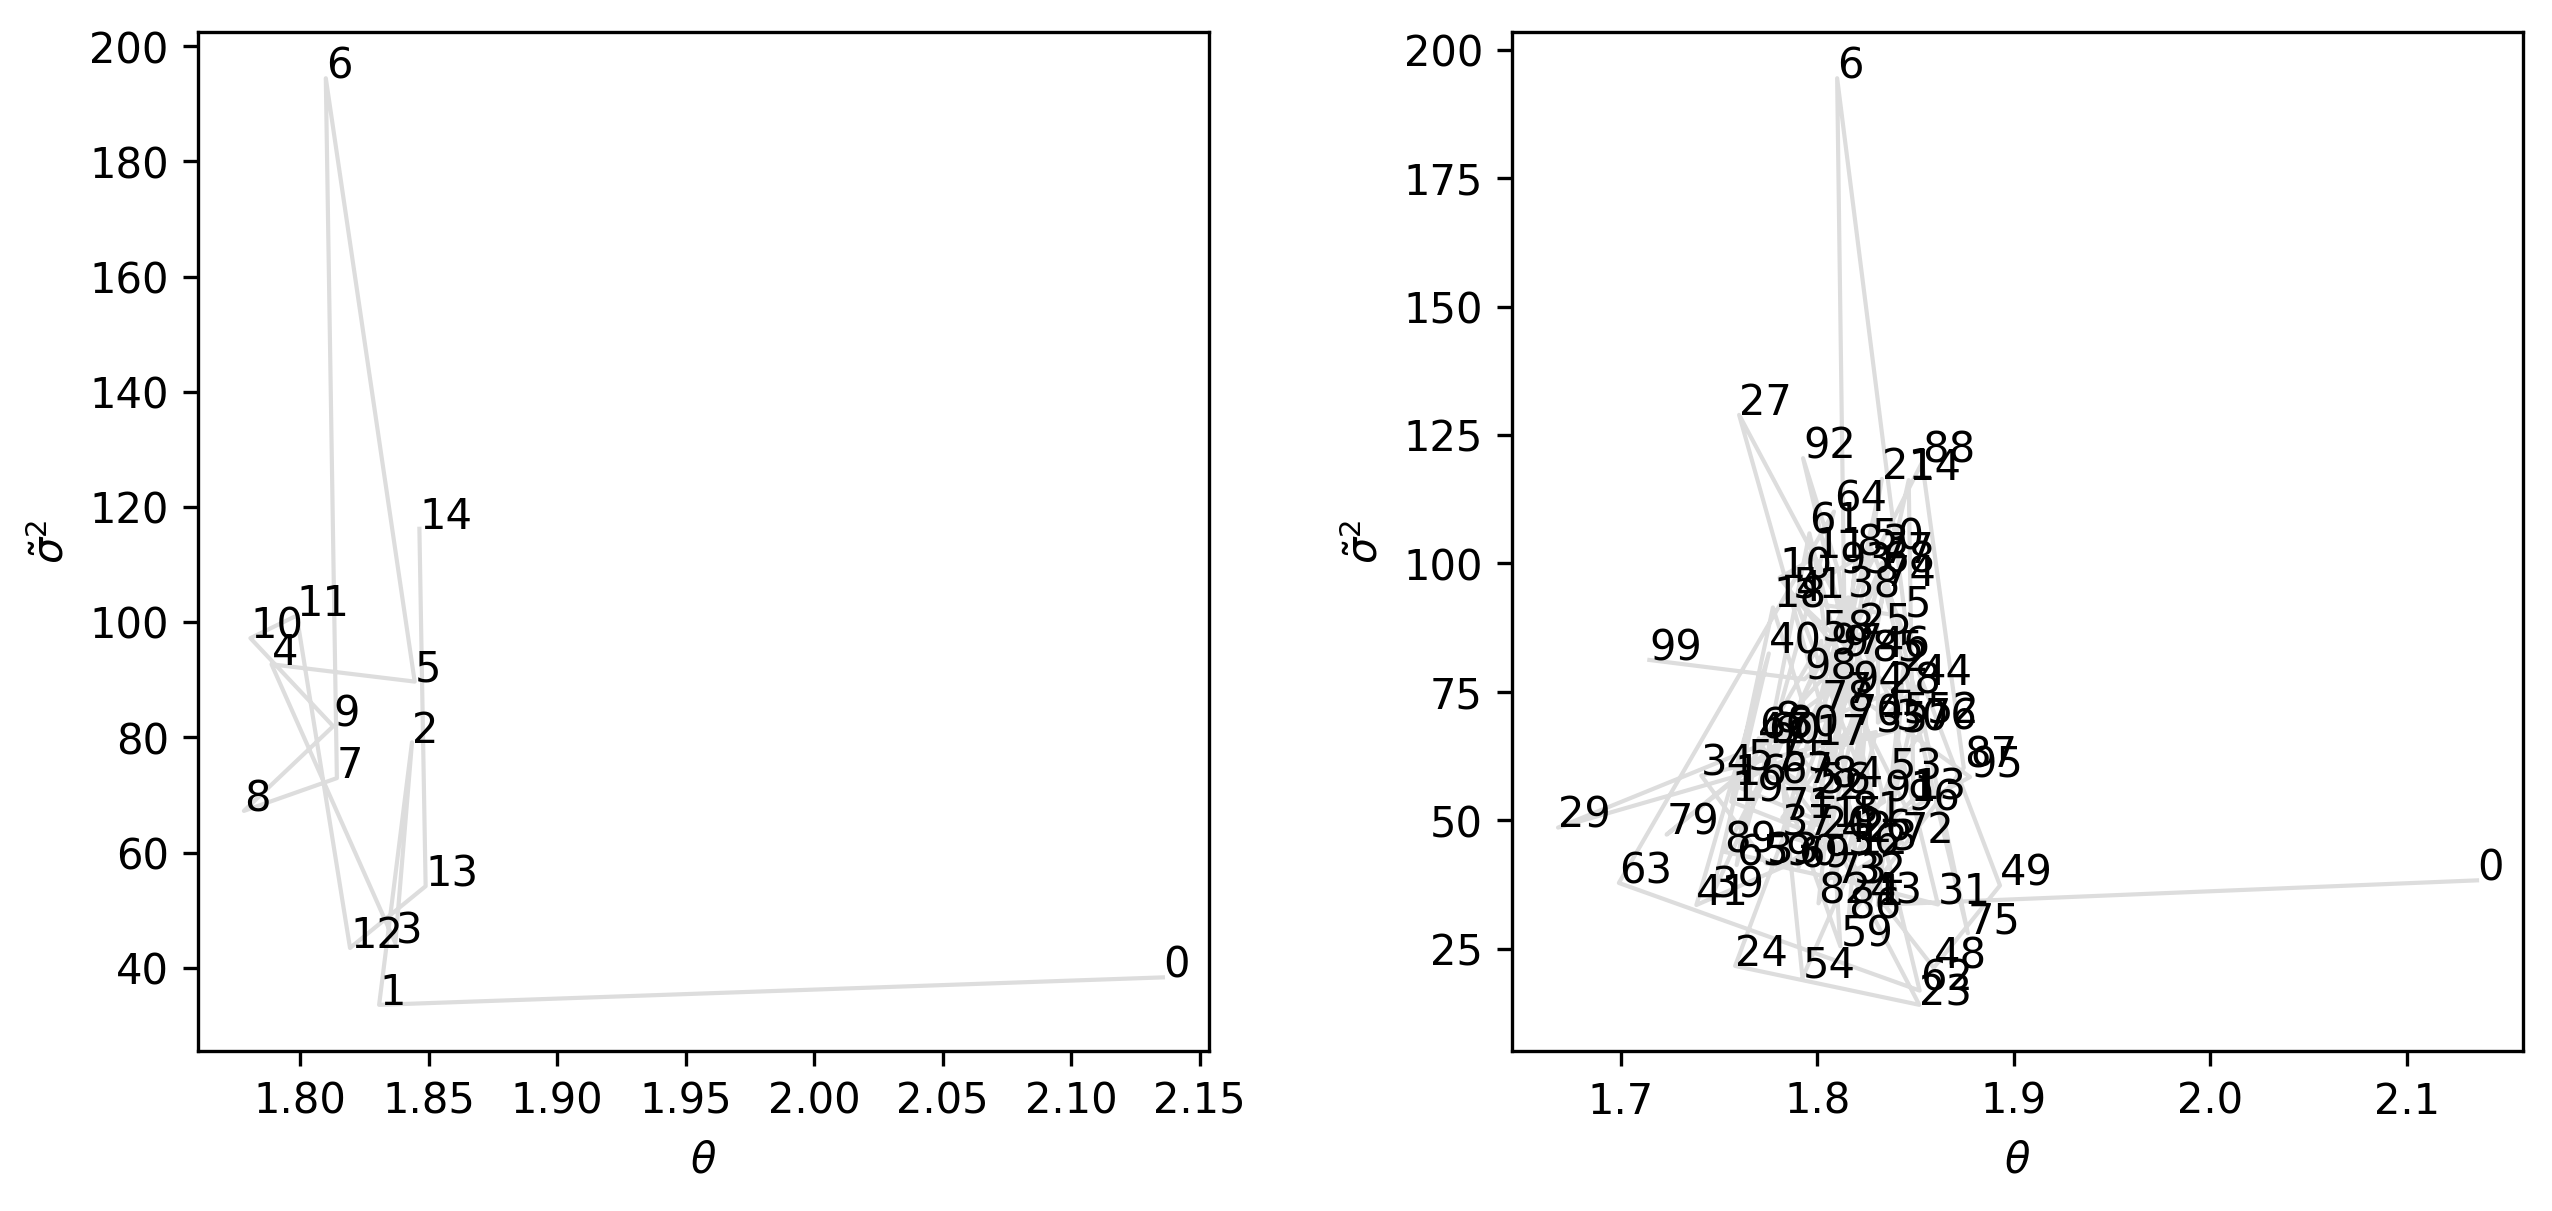

In [7]:
# grafico del algoritmo
# este gráfico no se acostumbra hacer en la práctica
f, axes = plt.subplots(1, 2, figsize = (10,4.5), dpi = 300)
plt.subplots_adjust(wspace = 0.3, hspace =0.2)

m1 = 15
axes[0].plot(PHI[:m1,0], PHI[:m1,1], linewidth = 1, color = "#dddddd")
for i in range(m1):
    axes[0].text(PHI[i,0], PHI[i,1],i)
axes[0].set_xlabel(r"$\theta$")
axes[0].set_ylabel(r"$\tilde{\sigma}^2$")
    
m1 = 100
axes[1].plot(PHI[:m1,0], PHI[:m1,1], linewidth = 1, color = "#dddddd")
for i in range(m1):
    axes[1].text(PHI[i,0], PHI[i,1],i)
axes[1].set_xlabel(r"$\theta$")
axes[1].set_ylabel(r"$\tilde{\sigma}^2$")

plt.show()

#### Distribuciones posterior y marginales

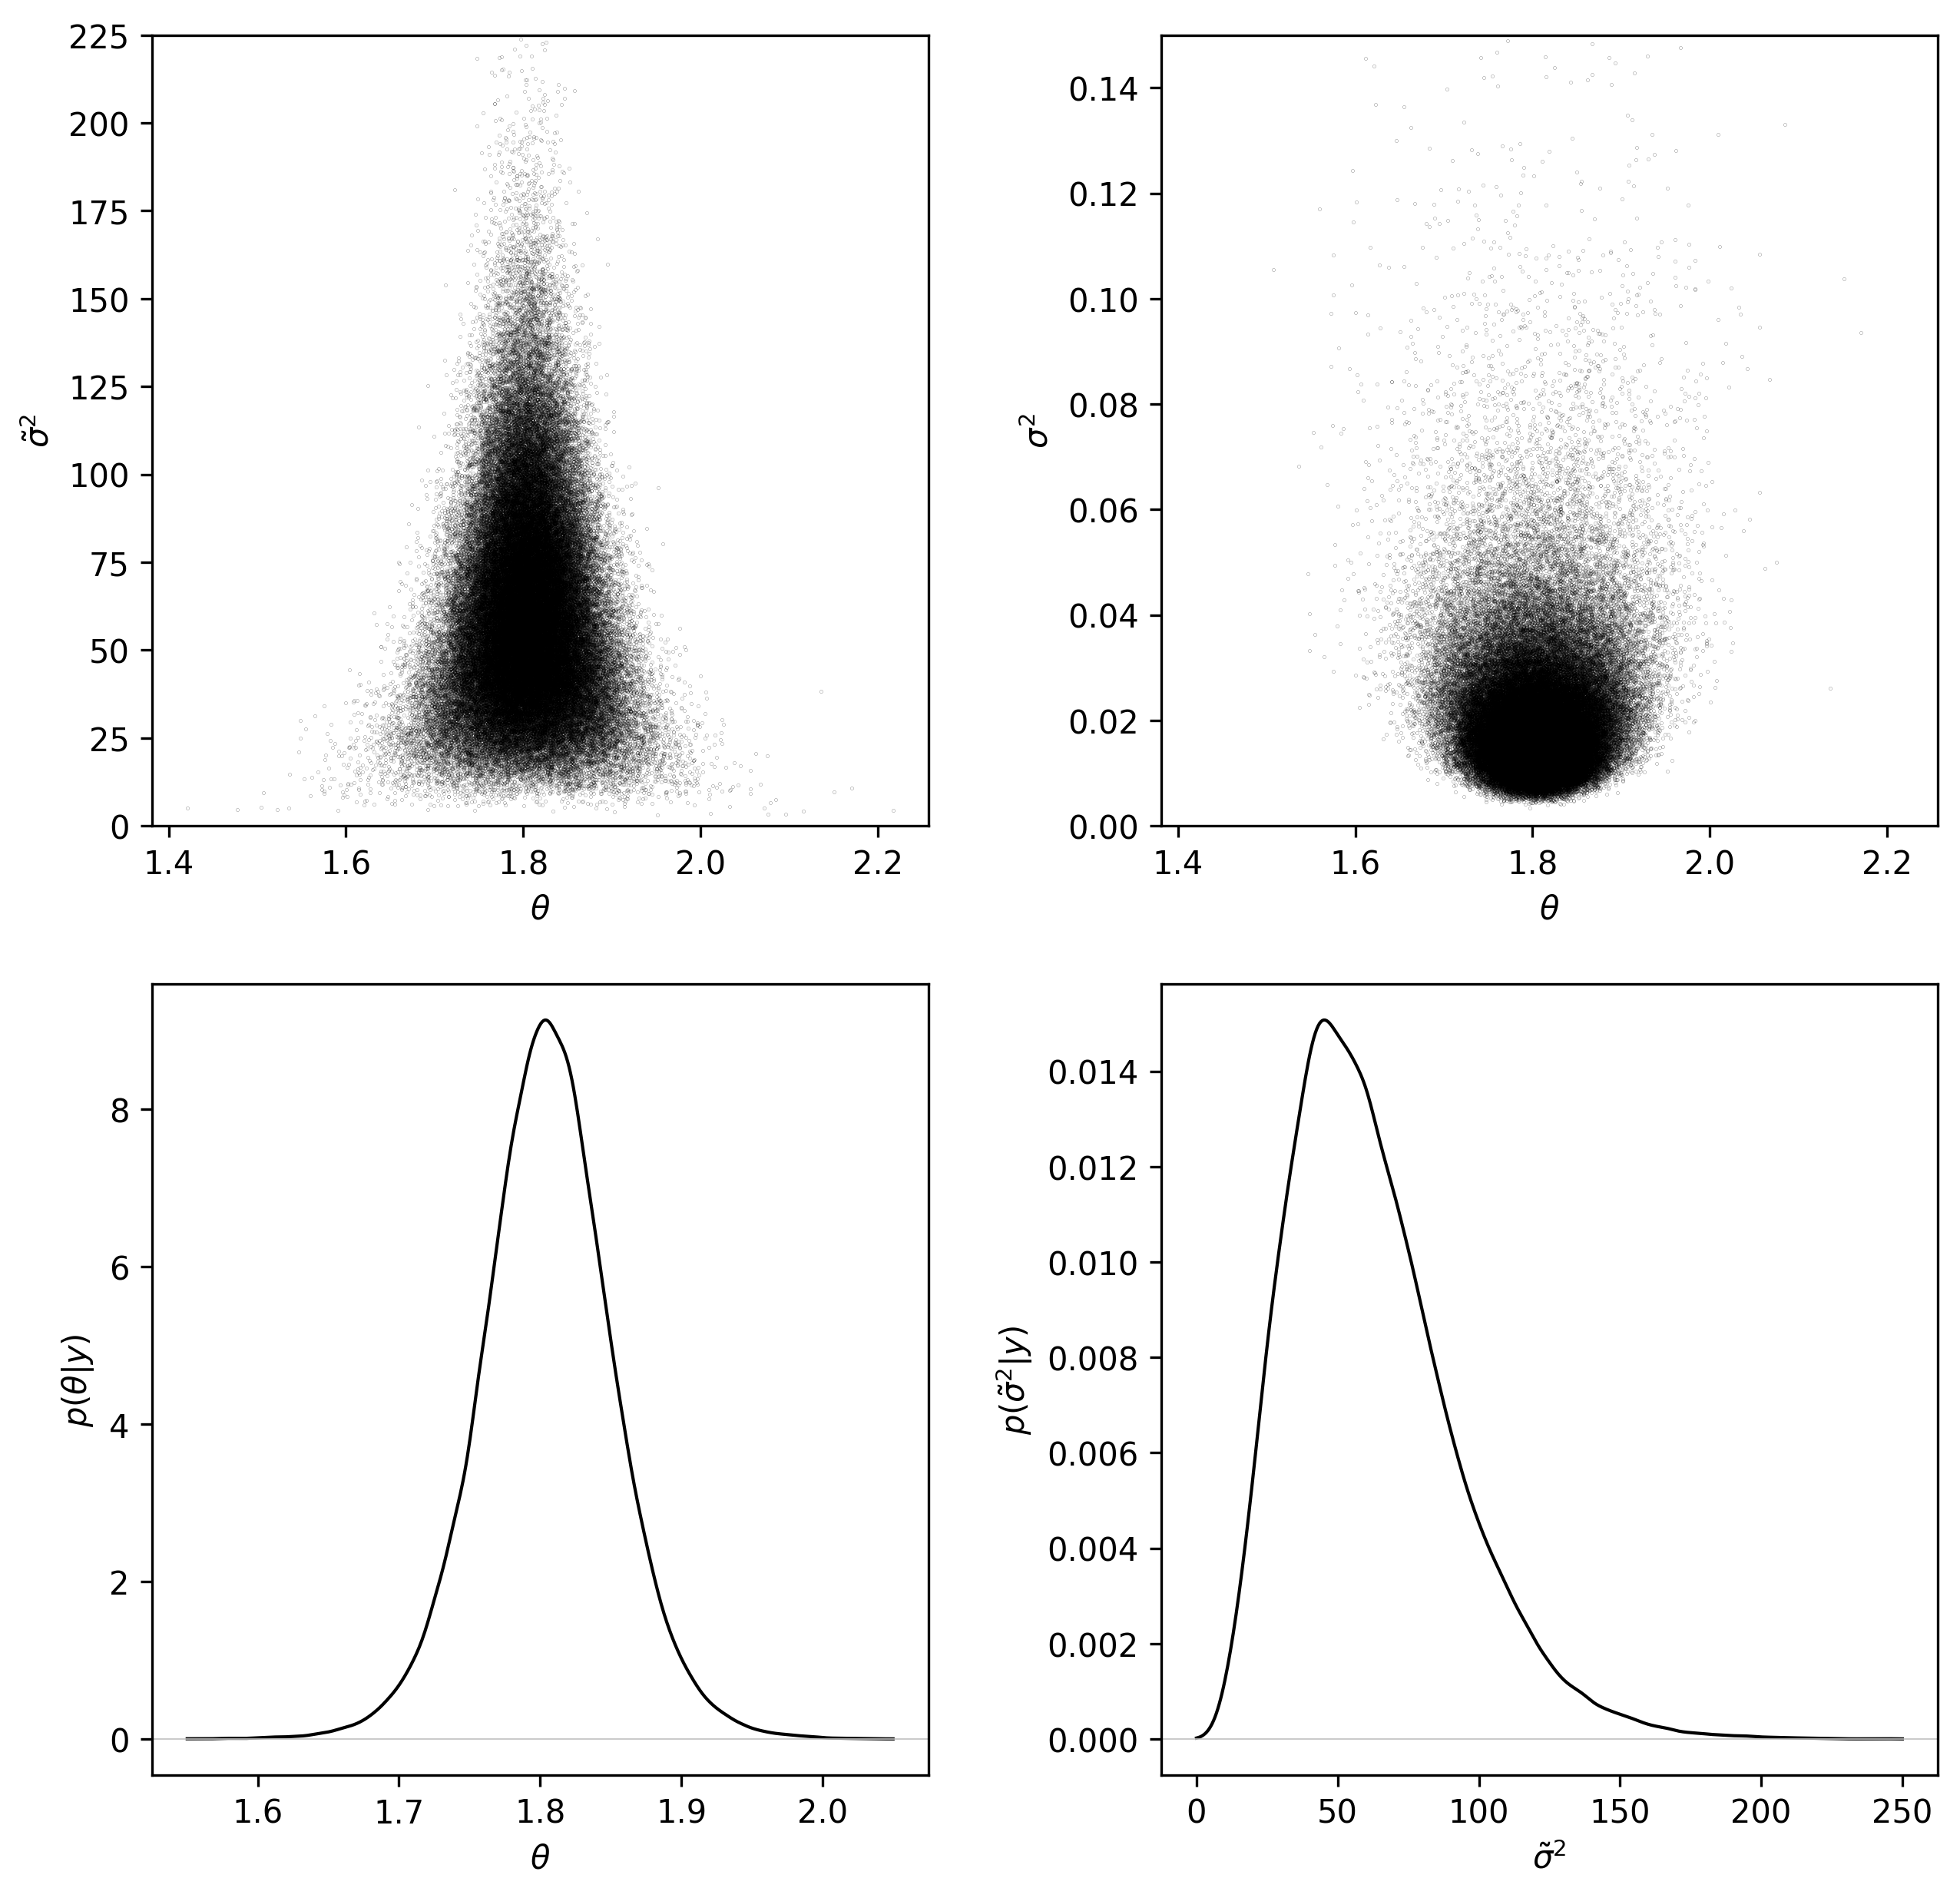

In [8]:
f, axes = plt.subplots(2, 2, figsize = (10,10),dpi = 300)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
# distribución conjunta
axes[0,0].scatter(PHI[:,0], PHI[:,1], marker = '.',s=0.01,color = "#000000")
axes[0,0].set_xlabel(r"$\theta$")
axes[0,0].set_ylabel(r"$\tilde{\sigma}^2$")
axes[0,0].set_ylim((0,225))
# distribución conjunta
axes[0,1].scatter(PHI[:,0],1/PHI[:,1], marker = '.', s = 0.01, color = "#000000")
axes[0,1].set_xlabel(r"$\theta$")
axes[0,1].set_ylabel(r"$\sigma^2$")
axes[0,1].set_ylim((0,0.15))
# theta
theta = np.linspace(1.55,2.05,500)
axes[1,0].plot(theta,st.gaussian_kde(PHI[:,0])(theta), color = 'black', linewidth = 1)
axes[1,0].axhline(y = 0, color = '#c0c0c0', linewidth = 0.4)
axes[1,0].set_xlabel(r"$\theta$")
axes[1,0].set_ylabel(r"$p(\theta|y)$")
# precision
isig2 = np.linspace(0,250,500)
axes[1,1].plot(isig2,st.gaussian_kde(PHI[:,1])(isig2), color = 'black', linewidth = 1)
axes[1,1].axhline(y = 0, color = '#c0c0c0', linewidth = 0.4)
axes[1,1].set_xlabel(r"$\tilde{\sigma}^2$")
axes[1,1].set_ylabel(r"$p(\tilde{\sigma}^2|y)$")

plt.show()

#### Inferencia

In [9]:
# intervalo de credibilidad
# media
tab = pd.DataFrame(data = [np.quantile(PHI[:,0], q = [0.025,0.5,0.975])], columns = ["2.5%", "50%","97.5%"])
round(tab,3)

2.5%    50%  97.5%
0  1.71  1.805  1.901

In [10]:
# precision
tab = pd.DataFrame(data = [np.quantile(PHI[:,1], q = [0.025,0.5,0.975])], columns = ["2.5%", "50%","97.5%"])
round(tab,3)

2.5%     50%   97.5%
0  18.376  57.543  131.15

In [11]:
# desviacion estandar
tab = pd.DataFrame(data = [np.quantile(1/np.sqrt(PHI[:,1]), q = [0.025,0.5,0.975])], columns = ["2.5%", "50%","97.5%"])
round(tab,3)

2.5%    50%  97.5%
0  0.087  0.132  0.233

In [12]:
# coeficiente de variación
tab = pd.DataFrame(data = [np.quantile((1/np.sqrt(PHI[:,1]))/PHI[:,0], q = [0.025,0.5,0.975])], columns = ["2.5%", "50%","97.5%"])
round(tab,3)

2.5%    50%  97.5%
0  0.048  0.073   0.13

In [13]:
round(np.mean(PHI[:,0]>1.8), 3)

0.548

### 2.2 Algoritmo general

Dado un **estado actual** de los parámetros del modelo $\boldsymbol{\theta}^{(b)} = \left(\theta_1^{(b)},\ldots,\theta_k^{(b)}\right)$, se genera un nuevo estado $\boldsymbol{\theta}^{(b+1)}$ como sigue:

1. Muestrear $\theta_1^{(b+1)}\sim p\left(\theta_1\mid\theta_2^{(b)},\theta_3^{(b)},\ldots,\theta_k^{(b)}\right)$.
2. Muestrear $\theta_2^{(b+1)}\sim p\left(\theta_2\mid\theta_1^{(b+1)},\theta_3^{(b)},\ldots,\theta_k^{(b)}\right)$.
3. Muestrear $\theta_3^{(b+1)}\sim p\left(\theta_3\mid\theta_1^{(b+1)},\theta_2^{(b+1)},\ldots,\theta_k^{(b)}\right)$.
4. ...
5. Muestrear $\theta_k^{(b+1)}\sim p\left(\theta_k\mid\theta_1^{(b+1)},\theta_2^{(b+1)},\ldots,\theta_{k-1}^{(b+1)}\right)$.
6. Establecer $\boldsymbol{\theta}^{(b+1)} = \left(\theta_1^{(b+1)},\ldots,\theta_k^{(b+1)}\right)$.
7. Repetir los pasos 1. a 6. hasta convergencia.

Este algoritmo genera una **secuencia dependiente** de parámetros $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ de la distribución posterior $p(\theta_1,\ldots,\theta_k\mid \boldsymbol{y})$.

Observe que $\boldsymbol{\theta}^{(b+1)}$ depende únicamente de $\boldsymbol{\theta}^{(b)}$ lo cual sugiere que $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ define una **cadena de Markov** (*Markov chain*).

***Smith, A. F., & Roberts, G. O. (1993). Bayesian computation via the Gibbs sampler and related Markov chain Monte Carlo methods. Journal of the Royal Statistical Society: Series B (Methodological), 55(1), 3-23.***


### 2.3 Cadenas de Markov

Un **proceso estocástico** es una colección de variables aleatorias $\{\theta_t\in S:t\in T\}$ para algún **espacio de estados** $S$ bien sea **discreto**, e.g., $\{1,\ldots,k\}$, o continuo, e.g., $(-\infty,\infty)$, y un **conjunto de índices** $T$, bien sea **discreto**, e.g., $\{0,1,\ldots\}$), o continuo, e.g., $[0,\infty)$.

Un proceso estocástico $\{\theta_t\in S:t\in T\}$, con $T=\{0,1,\ldots\}$, se denomina **cadena de Markov** si, para todo $A\subset S$, se tiene que
$$
\textsf{Pr}(\theta_{t+1}\in A\mid \theta_0,\ldots,\theta_t) = \textsf{Pr}(\theta_{t+1}\in A\mid\theta_t)\,.
$$
Una **cadena de Markov** es una clase particular de proceso estocástico cuyos **estados pasados y futuros son independientes dado el estado actual**, i.e., para caracterizar probabilísticamente hacia dónde se moverá la cadena a continuación, no necesita saber dónde ha estado, **solo debe considerar dónde está ahora**.


#### Cadenas de Markov bien comportadas

- Un estado $i$ se denomina **periódico** (*periodic*) con periodo $d$ si es visitado después de un número de pasos múltiplo de un entero $d > 1$.
- Una cadena se denomina **aperiódica** (*aperiodic*) si para todos los estados se tiene que tal múltiplo no existe (i.e., $d=1$).
- Una cadena se denomina **positiva recurrente** (*positive recurrent*) si para todos los estados $i$:
    * Si el proceso comienza en un estado $i$ regresará a $i$ con probabilidad 1. 
    * El tiempo de espera medio para el regreso al estado $i$ es finito.
      
- Una cadena se denomina **ergódica** (*ergodic*) si es  **aperiódica** y **positiva recurrente**. 

#### Teorema Ergódico

Las **cadenas de Markov ergódicas** poseen una **distribución estacionaria** única $\pi(\theta)$. Esta distribución caracteriza el **comportamiento que adopta la cadena después de evolucionar mucho tiempo**, independientemente de su estado inicial.

**(Teorema Ergódico.)** Si una cadena de Markov $\{\theta_t\in S:t\in T\}$ es **ergódica** y si $f$ es una función de valor real tal que $\textsf{E}_\pi|f(\theta)|<\infty$, entonces, con probabilidad 1, cuando $B\rightarrow\infty$ se tiene que
$$
\frac{1}{B}\sum_{b=1}^B f(\theta_b) \longrightarrow \textsf{E}_{\pi(\theta)}(f(\theta))
$$
donde el valor esperado de $f(\theta)$ se toma respecto a la **distribución estacionaria** $\pi(\theta)$.

El teorema **no dice nada** sobre tres aspectos prácticos fundamentales: 

- ¿Cuál debe ser el mejor punto de partida?
- ¿Cuánto tiempo se debe esperar para lograr la estacionariedad?
- ¿Cuánto tiempo se debe monitorear después de eso?

Siempre que la distribución estacionaria sea la distribución posterior, se puede **aprender con precisión arbitraria** sobre **cualquier aspecto de la distribución posterior**. simplemente **esperando lo suficiente a que se logre la estacionariedad** y monitoreando a partir de entonces un período lo suficientemente largo.


### 2.4 Resumen

La idea es simular muestras de la distribución posterior $p(\boldsymbol{\theta}\mid\boldsymbol{y})$, por medio de una **cadena de Markov** con las siguientes características:

- Debe tener el **mismo espacio de estados** que $\boldsymbol{\theta}$.
- Debe ser **fácil de simular** (muestrear).
- Debe tener a $p(\boldsymbol{\theta}\mid\boldsymbol{y})$ como **distribución estacionaria**.

Se demuestra que una **cadena de Markov** construida a partir del **muestreador de Gibbs** es **ergódica** y tiene la **distribución posterior** como **distribución estacionaria**, sin importar el punto de partida de la cadena (algunos puntos de partida pueden ser mejores que otros). 

La secuencia $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ se puede usar tal y como se tratara de una muestra aleatoria de valores de $\boldsymbol{\theta}$ provenientes de la distribución posterior $p(\boldsymbol{\theta}\mid y)$. Esto es,
$$
\frac{1}{B} \sum_{b=1}^{B} g(\boldsymbol{\theta}) \longrightarrow \textsf{E}[g(\boldsymbol{\theta}) \mid \boldsymbol{y}]=\int_{\Theta} g(\boldsymbol{\theta})\, p(\boldsymbol{\theta} \mid \boldsymbol{y})\,\textsf{d}\boldsymbol{\theta}\qquad\text{cuando}\qquad B\rightarrow \infty\,.
$$

El punto de partida $\boldsymbol{\theta}^{(0)}$ es arbitrario y usualmente se muestrea de la distribución previa.

El **muestreador de Gibbs** hace parte de un conjunto de técnicas de aproximación denominadas **cadenas de Markov de Monte Carlo** (*Markov Chain Monte Carlo*, MCMC).

Los métodos de MCMC constituyen **técnicas de aproximación numérica**, **no son modelos**, **no generan más información** además de la contenida en $\boldsymbol{y}$.


### 2.5 Diagnósticos de convergencia (estacionariedad)

**Preguntas:**

- ¿Cual debe ser el punto de partida?
- ¿La cadena alcanzo el equilibrio?
- Una vez alcanzado el equilibrio, ¿cuánto más se debe monitorear para lograr buenas aproximaciones?

Para que las **aproximaciones a las cantidades posteriores sean precisas**, se necesita que la distribución empírica de $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ esté lo suficientemente cerca de $p(\boldsymbol{\theta}\mid y)$.

El muestreador de Gibbs produce **muestras que eventualmente van a converger** a la distribución objetivo, pero en algunos casos la **convergencia puede ser lenta** debido a la **autocorrelación** de los parámetros.

Es usual pensar en la secuencia $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ como la **trayectoria de una partícula** $\boldsymbol{\theta}$ moviéndose a lo largo del espacio de parámetros $\Theta$.

No es posible estar absolutamente seguro que la cadena ha convergido. **Solo se puede saber si no lo ha hecho.**



#### Serie

Permiten chequear **estacionariedad** (muestras de una parte de la cadena tienen una distribución similar a muestras de otra parte de la cadena). 

También permiten ver si la cadena está **mezclando** bien o no (en simulación de Monte Carlo la partícula se mueve libremente a cualquier región del espacio de parámetros, lo cual significa cero autocorrelación).

Para resolver problemas de estacionariedad se recomienda **correr la cadena con más iteraciones**.

#### Autocorrelación

La función de autocorrelación está dada por
$$
\operatorname{acf}_{t}(\theta)=\frac{\frac{1}{B-t} \sum_{b=1}^{B-t}\left(\theta^{(b)}-\bar{\theta}\right)\left(\theta^{(b+t)}-\bar{\theta}\right)}{\frac{1}{B-1} \sum_{b=1}^{B}\left(\theta^{(b)}-\bar{\theta}\right)^{2}}\qquad\text{donde}\qquad\bar{\theta} = \frac{1}{B}\sum_{b=1}^B \theta^{(b)}\,.
$$
Entre **mayor sea la autocorrelación**, se necesitan **más muestras** para obtener la precisión deseada.

Para resolver problemas de correlación se recomienda **adelgazar la cadena sistemáticamente** (muestreo sistemático de la cadena).

#### Tamaño efectivo de muestra

Las cadenas suelen estar autocorrelacionadas positivamente, por lo tanto contienen menos información que una secuencia de muestras iid de la distribución objetivo.

Se quiere establecer la cantidad de muestras iid que contendrían la misma información de la cadena.
$$
n_{\text{eff}}(\theta) = \frac{B}{1 + 2\sum_{t=1}^\infty \operatorname{acf}_{t}(\theta)}
$$
donde $\rho_t$ es la autocorrelación en el lag $t$. Comunmente, la suma se hace hasta que $\text{acf}_{t-1} + \text{acf}_t < 0$.

### Error estándar de Monte Carlo

El error estándar de Monte Carlo hace referencia a la variabilidad (desviación estándar) del promedio muestral respecto al tamaño efectivo de muestra:
$$
\textsf{EMC}(\hat\theta) = \frac{\textsf{DE}(\hat\theta)}{\sqrt{n_{\text{eff}}(\theta)}}
$$
donde $\textsf{DE}(\hat\theta) = \sqrt{\frac{1}{B-1}\sum_{b=1}^B (\theta^{(b))}-\bar\theta)^2}$ es la desviación estándar muestral de $\hat\theta$ y $n_{\text{eff}}$ es el tamaño efectivo de la muestra asociada con la cadena de $\theta$.


### 2.6 Ejemplo: Diagnósticos de convergencia

#### Series

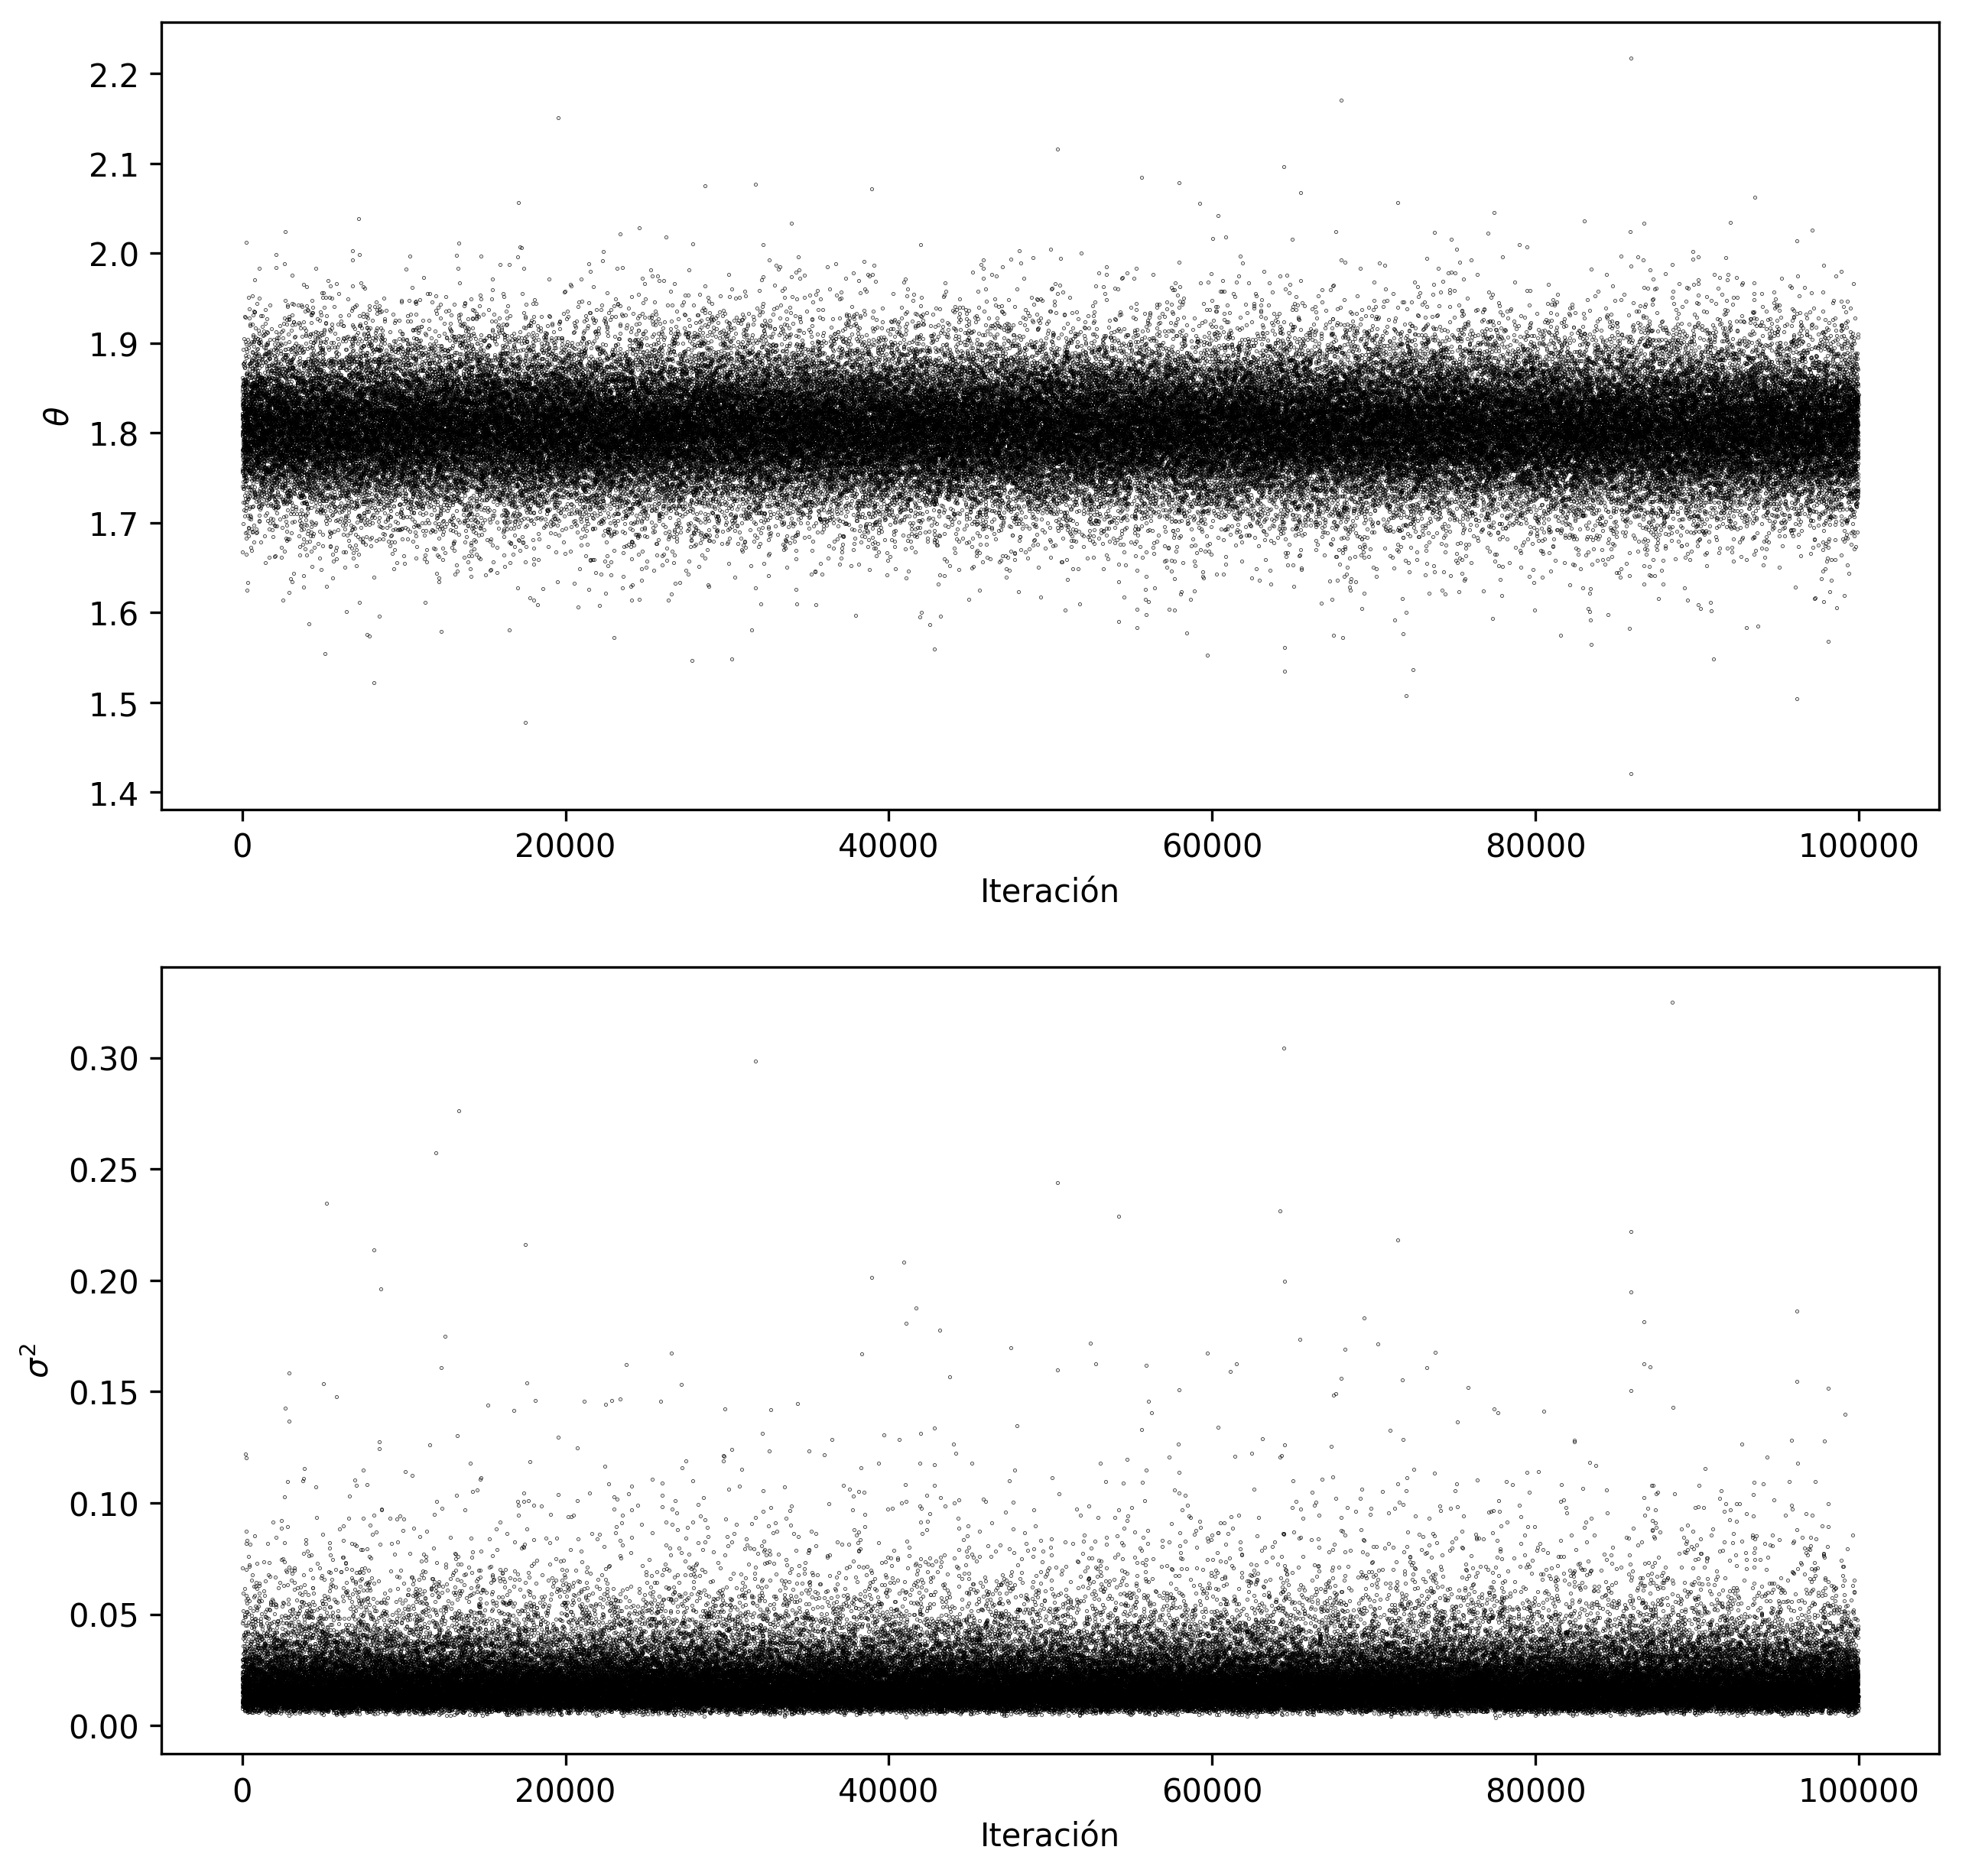

In [14]:
# cadenas
f, axes = plt.subplots(2, 1, figsize = (10,10), dpi = 300)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

axes[0].scatter(range(B-10), PHI[10:,0], marker = '.', s = 0.1, color = "black")
axes[0].set_xlabel("Iteración")
axes[0].set_ylabel(r"$\theta$")

axes[1].scatter(range(B-10), 1/PHI[10:,1], marker = '.', s = 0.1, color = "black")
axes[1].set_xlabel("Iteración")
axes[1].set_ylabel(r"$\sigma^2$")

plt.show()

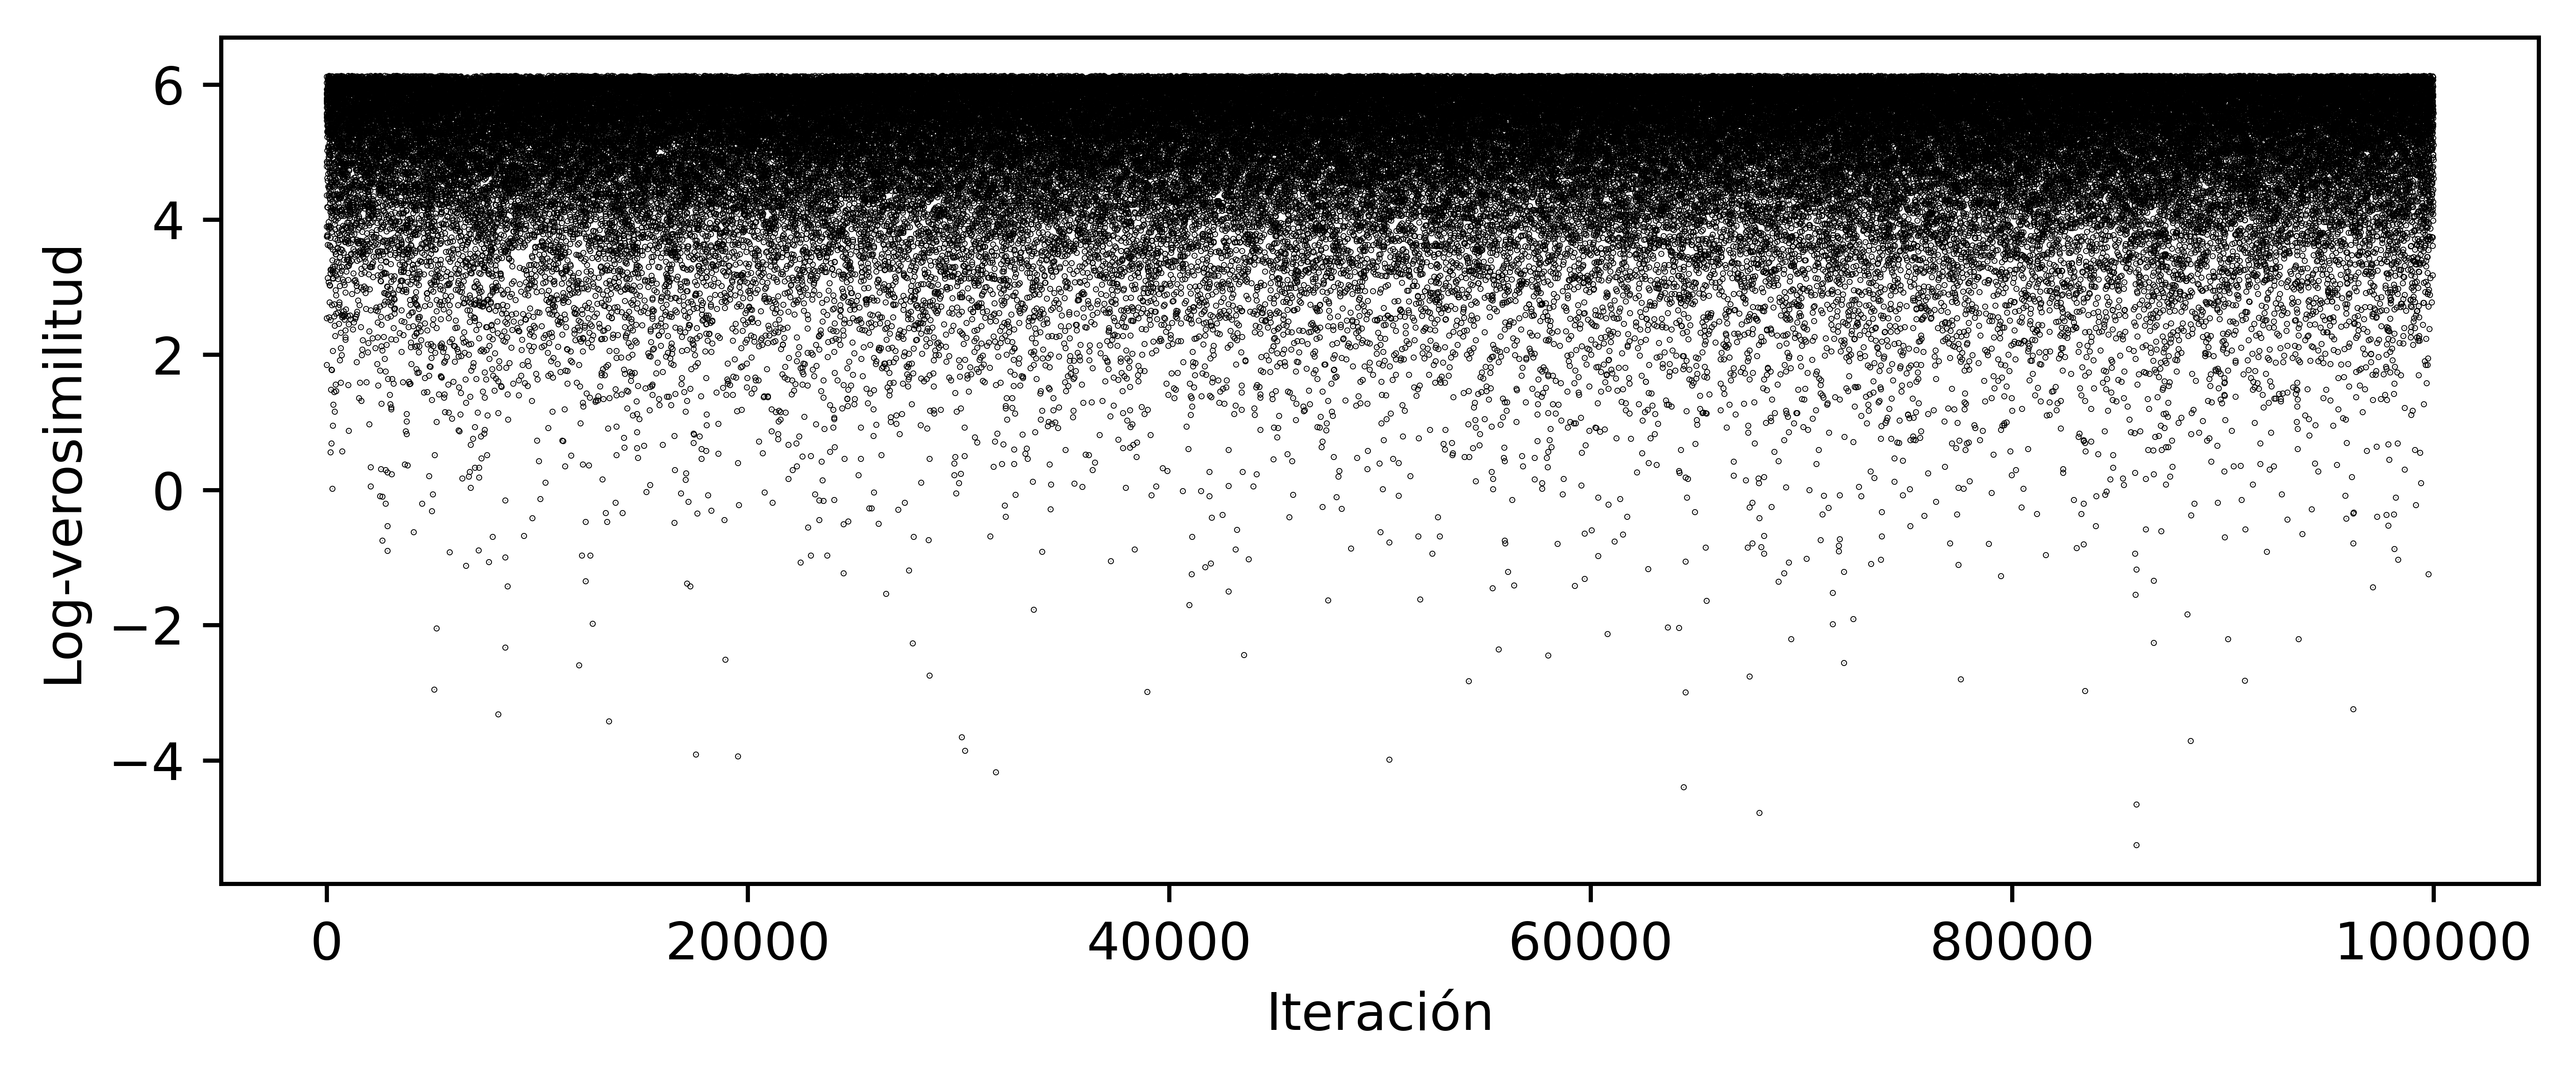

In [15]:
# log-verosimilitud
LL = []
for i in range(B):
    LL.append(np.sum(st.norm.logpdf(y, loc = PHI[i,0], scale = np.sqrt(1/PHI[i,1]))))
# cadena
fig = plt.figure(figsize = (8,3), dpi = 800)
ax = fig.add_subplot(111)
ax.scatter(range(B-10), LL[10:], marker = '.', s = 0.1, color = "black")
ax.set_xlabel("Iteración")
ax.set_ylabel("Log-verosimilitud")
plt.show()

#### Autocorrelación

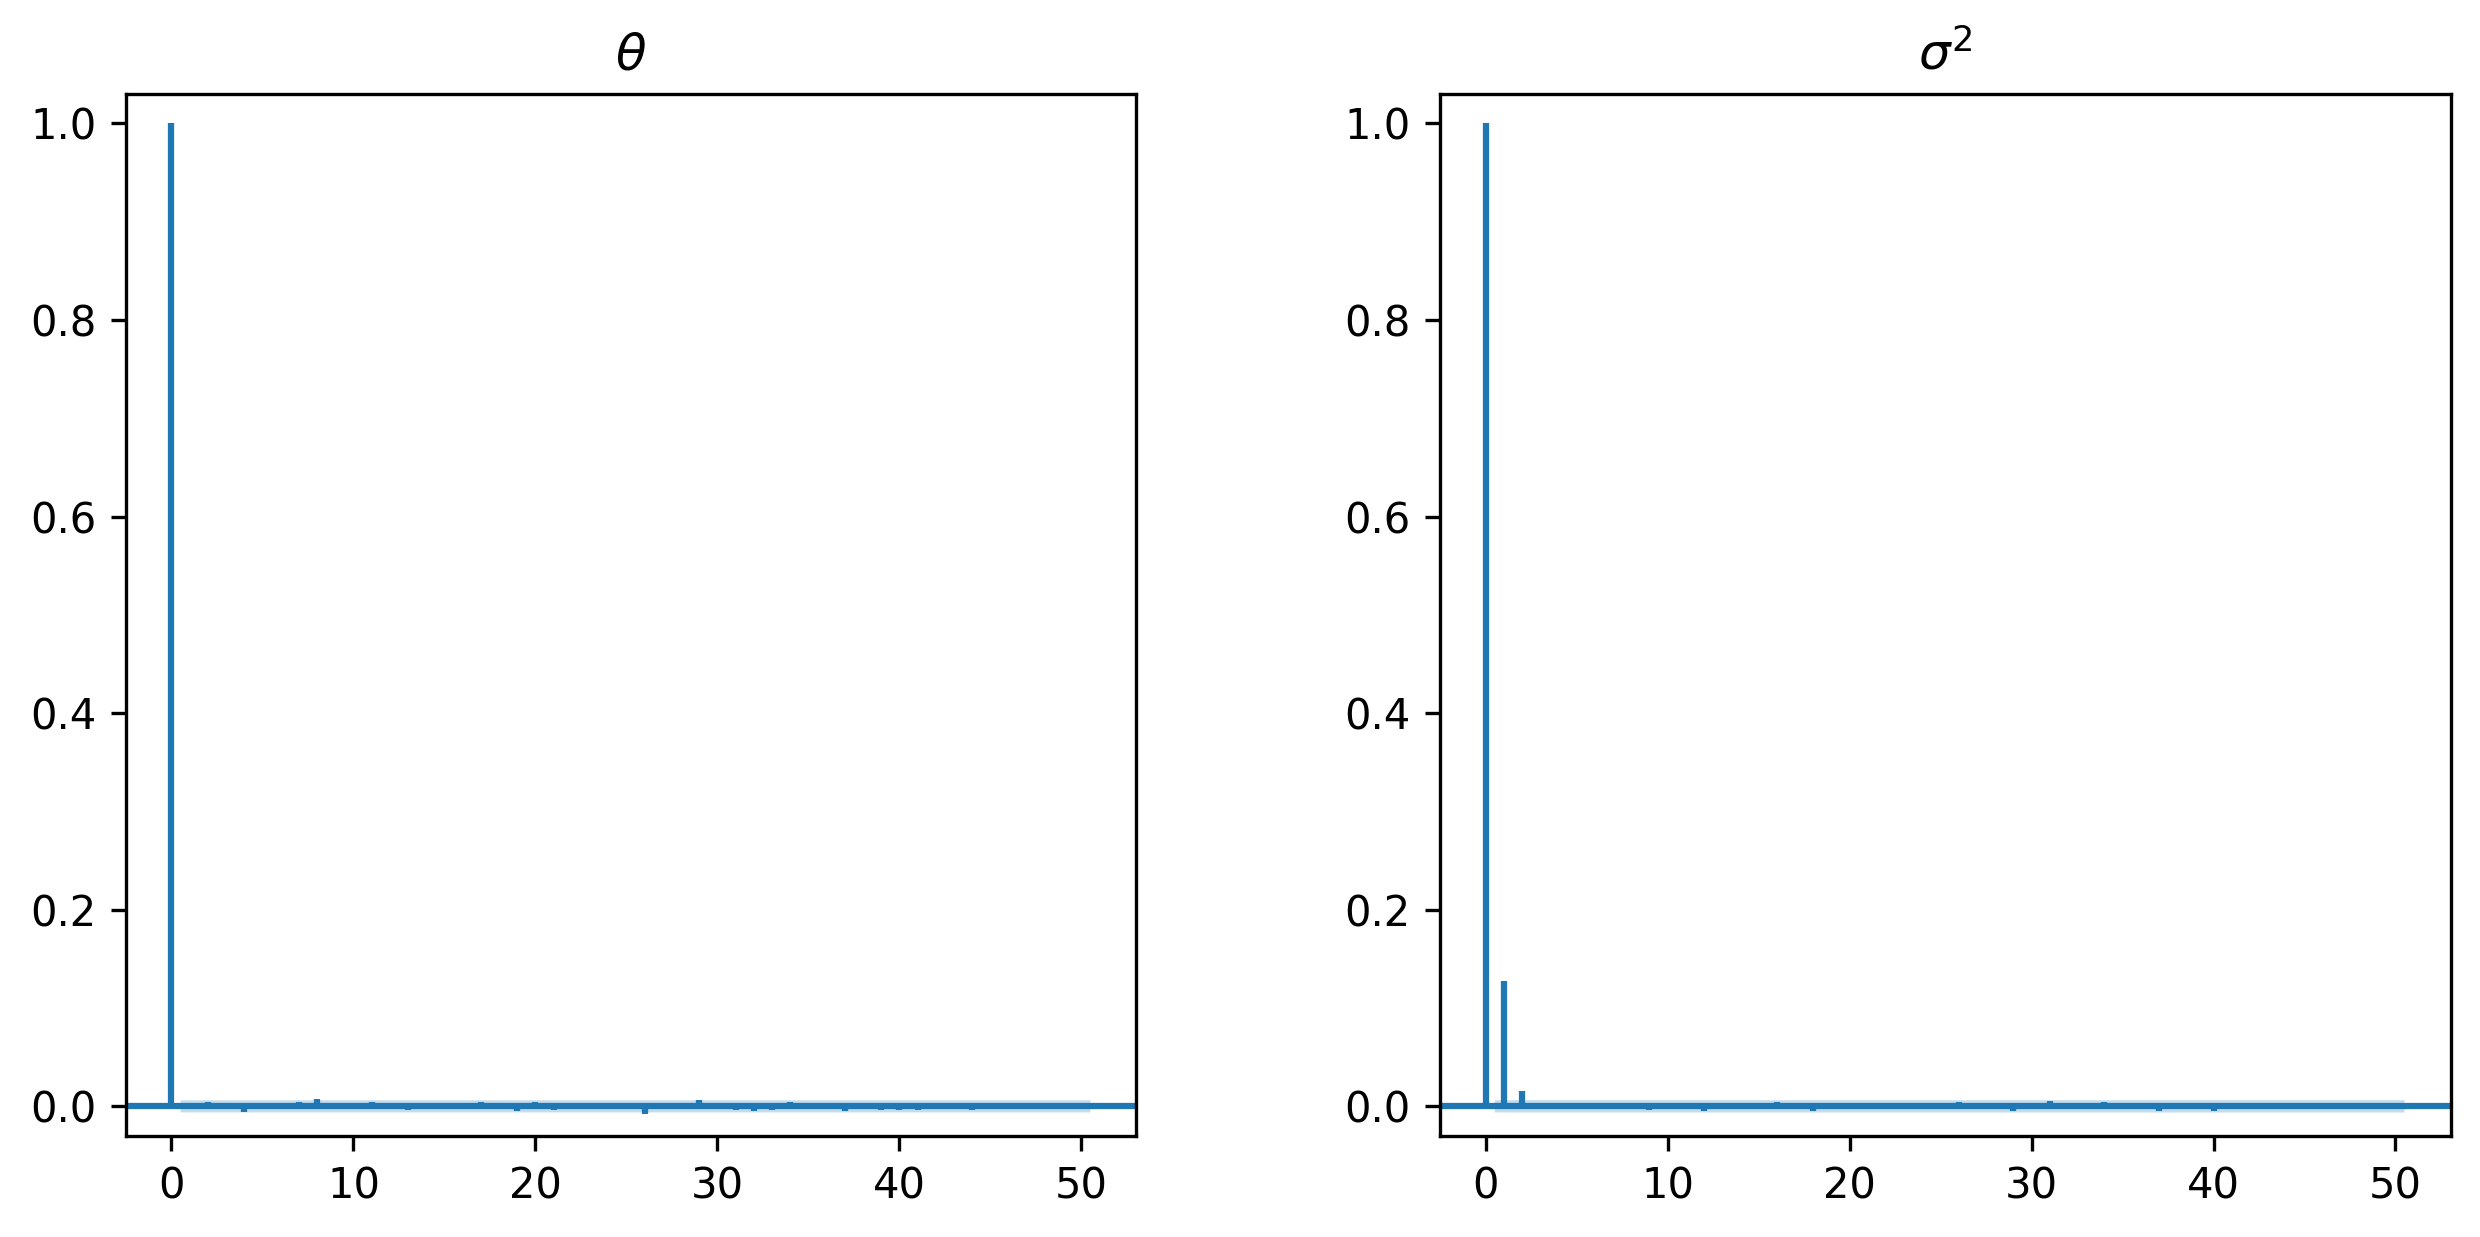

In [16]:
# autocorrelacion
f, axes = plt.subplots(1, 2, figsize = (10,4.6), dpi = 300)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)
plot_acf(PHI[:,0], lags = 50, ax = axes[0], marker = '', adjusted = True)
axes[0].set_title(r"$\theta$")
axes[0].set_ylim([-0.03,1.03])
plot_acf(1/PHI[:,1], lags = 50, ax = axes[1], marker = '', adjusted = True)
axes[1].set_title(r"$\sigma^2$")
axes[1].set_ylim([-0.03,1.03])
plt.show()

#### Tamaño efectivo de muestra

In [17]:
# Tamaño efectivo de la muestra
# https://arviz-devs.github.io/arviz/api/generated/arviz.ess.html
tem = [ess(PHI[:,0]),ess(PHI[:,1])]
tab = pd.DataFrame(data = [tem], columns = [r"$\theta$", r"$\tilde\sigma^2$"])
round(tab,2)

$\theta$  $\tilde\sigma^2$
0  99314.39          80477.59

#### Error estándar de Monte Carlo

In [18]:
# error estándar de Monte Carlo
ee = [np.std(PHI[:,i])/np.sqrt(ess(PHI[:,i])) for i in range(2)]
tab = pd.DataFrame(data = [ee], columns = [r"$\theta$", r"$\tilde\sigma^2$"])
round(tab,10)

$\theta$  $\tilde\sigma^2$
0  0.000152          0.103535

Ver https://cran.r-project.org/web/packages/bayesplot/vignettes/visual-mcmc-diagnostics.html y https://arviz-devs.github.io/arviz/api/diagnostics.html para más diagnósticos. para más diagnosticos.

## Referencias

<img src="Hoffcoverbook.jpg" width = 250 />

<img src="Gelmancoverbook.png" width = 250 />

<img src="Reichcoverbook.jpg" width = 250 />